# Supervised bias analysis CUB data 2019
#### Plots used for report *Addendum Bias prevented*

This notebook is used to answer the following questions about the CUB-process in 2019:

* Question 2a: Is there a relationship between the <u>combination</u> of criteria used in the risk profile and students with a migration background?

In the introduction of this notebook the data is loaded and prepared. Thereafter, the question is answered for the following bivariate combinations of criteria:
- education x age
- education x distance
- age x distance.

In [1]:
import warnings
import numpy as np
import pandas as pd
from helper_functions import *
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors

warnings.filterwarnings('ignore')

# Part 1 - Load and clean data

In [2]:
# loading data
sheet_name = 'Table 2'
df = pd.read_excel('../DUO_CUB_Netherlands_Statistics.xlsx', sheet_name=sheet_name, skiprows=3)

In [3]:
# delete '\n' and 'number' for each columns
df.columns = [col.replace('\n', '').replace('number', '').replace('()', '').strip() for col in df.columns]

# delete last two columns
df = df[:-2]

# make category columns the index column, delete Nr column
df.set_index('Category', inplace=True)
df.drop('Nr', axis=1, inplace=True)
df.head()

,Total,Country of birth:Born in NL,Country of birth:Born outside NL,Country of origin: NL,Country of origin:Europe (excl. NL),Country of origin:Outside Europe,Born in NL x country of origin NL,Born in NL x country of origin Europe (excl. NL),Born in NL x country of origin outside Europe,Born outside NL x country of origin Europe (excl. NL),Born outside NL x country of origin outside Europe
Category,,,,,,,,,,,
Total,50230.0,38190.0,12040.0,27890.0,2770.0,19580.0,27890.0,1570.0,8730.0,1190.0,10850.0
Education: mbo 1-2,10010.0,4290.0,5720.0,2470.0,330.0,7210.0,2470.0,170.0,1660.0,160.0,5560.0
Education: mbo 3-4,26620.0,21330.0,5290.0,14810.0,1550.0,10250.0,14810.0,900.0,5620.0,660.0,4630.0
Education: hbo,12230.0,11360.0,870.0,9600.0,740.0,1900.0,9600.0,460.0,1310.0,280.0,590.0
Education: wo,1370.0,1200.0,170.0,1010.0,140.0,210.0,1010.0,50.0,140.0,90.0,80.0


## Define new groups

In [4]:
# get number of columns except the first one, also get number of rows
n_col = len(df.columns) - 1
n_row = len(df)

# Columns - 3 categories
df['Migrants'] = df['Country of birth:Born outside NL']
df['Childs of migrant'] = df['Born in NL x country of origin Europe (excl. NL)'] + df['Born in NL x country of origin outside Europe']
df['Dutch origin'] = df['Born in NL x country of origin NL']

# Columns - 5 categories
## Migrants (1st gen)
df['Non-European migrants'] = df['Born outside NL x country of origin outside Europe']
df['European migrants'] = df['Born outside NL x country of origin Europe (excl. NL)']

## Childs of migrant(s) (2nd gen)
df['Childs non-European migrant'] = df['Born in NL x country of origin outside Europe']
df['Childs European migrant'] = df['Born in NL x country of origin Europe (excl. NL)']

## All migrants (total population without Dutch origin)
df['Migration background'] = df['Migrants'] + df['Childs of migrant']

## EU and non-EU migrants 
df['Non-European migration background'] = df['Born outside NL x country of origin outside Europe'] + df['Born in NL x country of origin outside Europe']
df['European migration background'] = df['Born outside NL x country of origin Europe (excl. NL)'] + df['Born in NL x country of origin Europe (excl. NL)']

# merge mbo 1-2 and 3-4 
df.loc['mbo', :] = df.loc['Education: mbo 1-2', :] + df.loc['Education: mbo 3-4', :]

# age mbo 1-2 and 3-4
df.loc['Age: 15-18 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 15-18 years',:] + df.loc['Education: mbo 3-4 & Age: 15-18 years',:]
df.loc['Age: 19-20 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 19-20 years',:] + df.loc['Education: mbo 3-4 & Age: 19-20 years',:]
df.loc['Age: 21-22 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 21-22 years',:] + df.loc['Education: mbo 3-4 & Age: 21-22 years',:]
df.loc['Age: 23-24 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 23-24 years',:] + df.loc['Education: mbo 3-4 & Age: 23-24 years',:]
df.loc['Age: 25-50 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 25-50 years',:] + df.loc['Education: mbo 3-4 & Age: 25-50 years',:]

# distance mbo 1-2 and 3-4
df.loc['Distance: 0km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 0km',:] + df.loc['Education: mbo 3-4 & Distance: 0km',:]
df.loc['Distance: 1m-1km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 1m-1km',:] + df.loc['Education: mbo 3-4 & Distance: 1m-1km',:]
df.loc['Distance: 1-2km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 1-2km',:] + df.loc['Education: mbo 3-4 & Distance: 1-2km',:]
df.loc['Distance: 2-5km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 2-5km',:] + df.loc['Education: mbo 3-4 & Distance: 2-5km',:]
df.loc['Distance: 5-10km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 5-10km',:] + df.loc['Education: mbo 3-4 & Distance: 5-10km',:]
df.loc['Distance: 10-20km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 10-20km',:] + df.loc['Education: mbo 3-4 & Distance: 10-20km',:]
df.loc['Distance: 20-50km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 20-50km',:] + df.loc['Education: mbo 3-4 & Distance: 20-50km',:]
df.loc['Distance: 50-500km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 50-500km',:] + df.loc['Education: mbo 3-4 & Distance: 50-500km',:]
df.loc['Distance: unknown (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: unknown',:] + df.loc['Education: mbo 3-4 & Distance: unknown',:]

# New columns about CUB process

# High risk (category 1 + 2), low risk (category 3 + 4 + 5) and unknown (category 6)
df.loc['High risk', :] = df.loc['Risk category 1', :] + df.loc['Risk category 2', :]
df.loc['Low risk', :]= df.loc['Risk category 3', :] + df.loc['Risk category 4', :] + df.loc['Risk category 5', :]
df.loc['Unknown risk', :] = df.loc['Risk category 6', :]

# High risk (category 1 + 2) and selected for hosue visit
df.loc['High risk and selected for control', :] = df.loc['Risk category 1 & Selected for control: yes', :] + df.loc['Risk category 2 & Selected for control: yes', :]
df.loc['High risk and not selected for control', :] = df.loc['Risk category 1 & Selected for control: no', :] + df.loc['Risk category 2 & Selected for control: no', :]
df.loc['Low risk and selected for control', :] = df.loc['Risk category 3 & Selected for control: yes', :] + df.loc['Risk category 4 & Selected for control: yes', :] + df.loc['Risk category 5 & Selected for control: yes', :]
df.loc['Low risk and not selected for control', :] = df.loc['Risk category 3 & Selected for control: no', :] + df.loc['Risk category 4 & Selected for control: no', :] + df.loc['Risk category 5 & Selected for control: no', :]
df.loc['Unknown risk and selected for control', :] = df.loc['Risk category 6 & Selected for control: yes', :]
df.loc['Unknown risk and not selected for control', :] = df.loc['Risk category 6 & Selected for control: no', :]

## Groups of interest

In [5]:
# entire population
year = 2019
total_pop = ['Totaal']
total_pop_mbo = ['mbo']
n_total_pop = '{:,}'.format(int(df.loc['Total','Total'])).replace(',','.')
n_total_pop_mbo = '{:,}'.format(int(df.loc['mbo','Total'])).replace(',','.')

# migrants, childs of migrant and Dutch origin 
col_mig = ['Migrants', 'Childs of migrant', 'Dutch origin']

# migration background and Dutch origin
col_mig_binary = ['Migration background', 'Dutch origin']

# EU migrants, non-EU migrants and Dutch origin
col_mig_eu = ['Non-European migration background','European migration background', 'Dutch origin']

# all migrant categories
col_mig_all = ['Non-European migrants', 'European migrants', 'Childs non-European migrant', 'Childs European migrant', 'Dutch origin']

# all risk categories
risk_cat_all = ['Risk category 1', 'Risk category 2', 'Risk category 3', 'Risk category 4', 'Risk category 5', 'Risk category 6']

# education categories
cat_education = ['Education: mbo 1-2', 'Education: mbo 3-4', 'Education: hbo', 'Education: wo']
cat_education_mbo = ['Education: mbo 1-2', 'Education: mbo 3-4']

# age categories
cat_age = ['Age: 15-18 years', 'Age: 19-20 years', 'Age: 21-22 years', 'Age: 23-24 years', 'Age: 25-50 years']
cat_age_mbo = ['Age: 15-18 years (mbo)', 'Age: 19-20 years (mbo)', 'Age: 21-22 years (mbo)', 'Age: 23-24 years (mbo)', 'Age: 25-50 years (mbo)']

# distance categories
cat_distance = ['Distance: 0km', 'Distance: 1m-1km', 'Distance: 1-2km', 'Distance: 2-5km', 'Distance: 5-10km', 'Distance: 10-20km', 'Distance: 20-50km', 'Distance: 50-500km', 'Distance: unknown']
cat_distance_mbo = ['Distance: 0km (mbo)', 'Distance: 1m-1km (mbo)', 'Distance: 1-2km (mbo)', 'Distance: 2-5km (mbo)', 'Distance: 5-10km (mbo)', 'Distance: 10-20km (mbo)', 'Distance: 20-50km (mbo)', 'Distance: 50-500km (mbo)', 'Distance: unknown (mbo)']

# selected for control procedure
selected_binary = ['Selected for control: yes', 'Selected for control: no']

# high and low risk, incl. selected yes/no for control procedure
H_L_risk_selected = ['High risk', 'Selected for control: yes',  'Low risk', 'Selected for control: no']

# high risk and selected yes/no for control procedure
H_risk_selected = ['High risk and selected for control', 'High risk and not selected for control']

# low risk and selected yes/no for control procedure
L_risk_selected = ['Low risk and selected for control', 'Low risk and not selected for control']

# unknown risk and yes/no for control procedure
O_risk_selected = ['Unknown risk and selected for control', 'Unknown risk and not selected for control']

## Color template

# Education x Age

## 2 groups: migration background and Dutch origin

### wo, hbo and mbo students

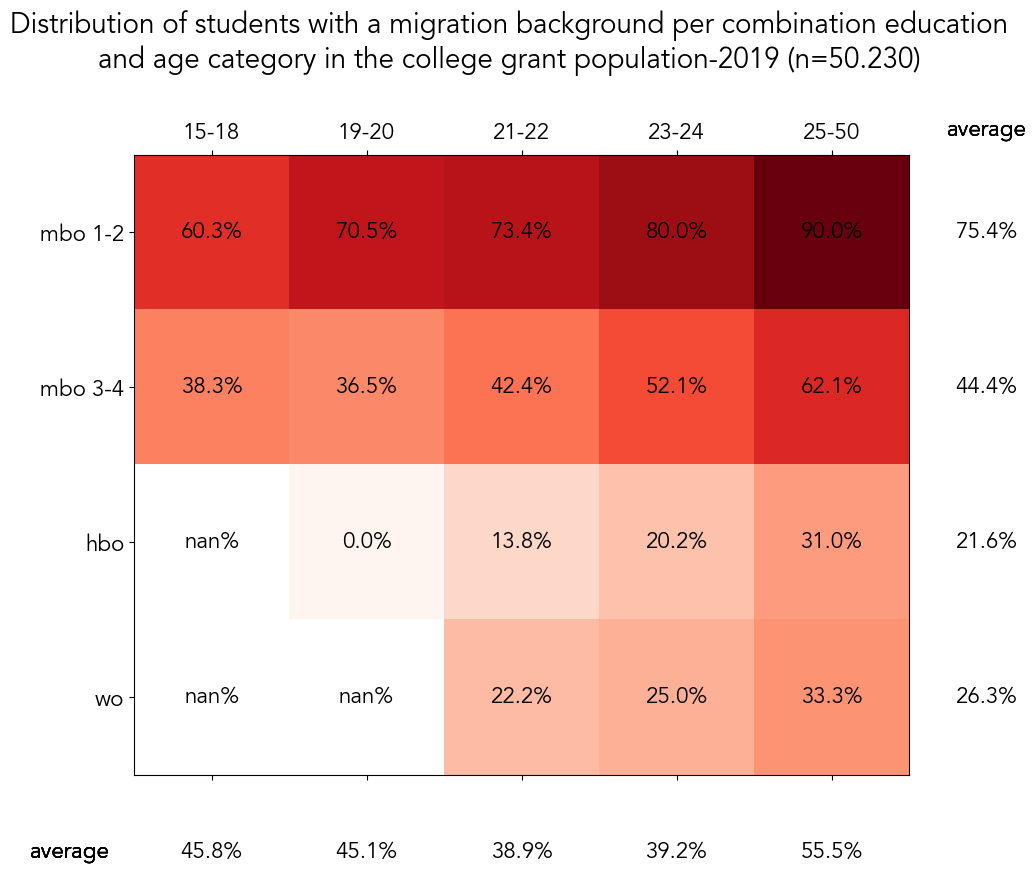

In [6]:
# create matrix for education x age
cat_combinations_education_age = [str(education) + ' & ' + str(age) for education in cat_education for age in cat_age]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_education_age = len(cat_education)
k_cols_matrix_education_age = len(cat_age)

# colors for heatmap
cmap_migr_back = 'Reds'

# create the matrix - education x age for migration background
matrix_education_age_total = get_matrix(df, cat_combinations_education_age, 'Total', k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_migr_back = get_matrix(df, cat_combinations_education_age, metric, k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_migr_back_perc = matrix_education_age_migr_back / matrix_education_age_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education, metric)
marginals_ls_age = marginals(df, cat_age, metric)

# define the row and column names
row_names_education_age = ['mbo 1-2', 'mbo 3-4', 'hbo', 'wo']
col_names_education_age = ['15-18', '19-20', '21-22', '23-24', '25-50']
title_education_age = f'Distribution of students with a migration background per combination education\nand age category in the college grant population-{year} (n={n_total_pop})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_age_migr_back_perc, 
                  row_names_education_age, 
                  col_names_education_age, 
                  cmap=cmap_migr_back, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_age],
                  rotation=0,
                  label_as_percentage=True,
                  figure_title=title_education_age)

### mbo students

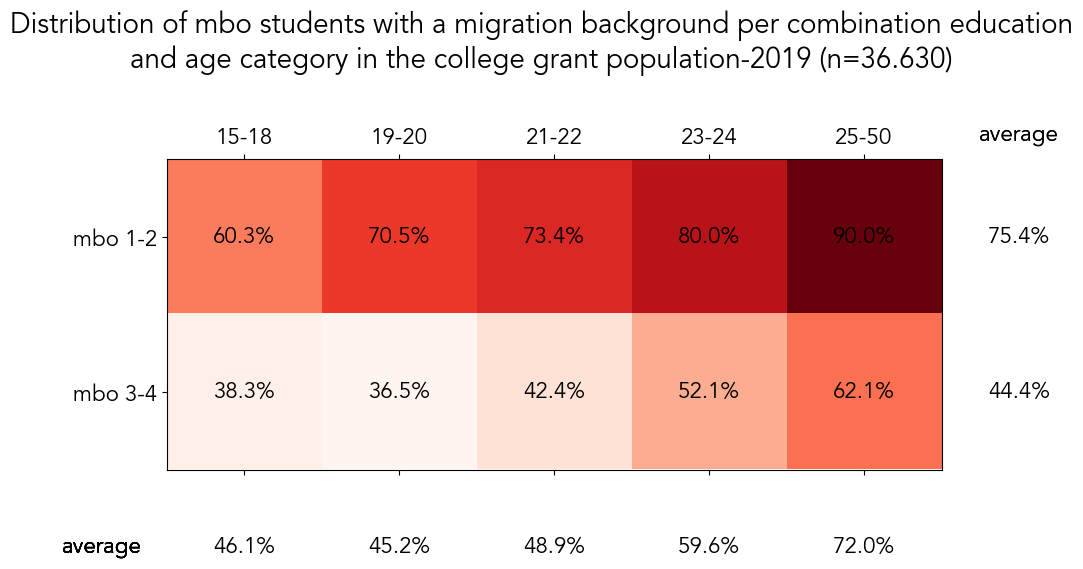

In [7]:
# create matrix for education x age
cat_combinations_education_age = [str(education) + ' & ' + str(age[:-6]) for education in cat_education_mbo for age in cat_age_mbo]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_education_age = len(cat_education_mbo)
k_cols_matrix_education_age = len(cat_age_mbo)

## color maps voor de heatmaps
cmap_migr_back = 'Reds'

# create the matrix - onderwijsvorm & leeftijd, total, migrants and childs of migrants, and percentage
matrix_education_age_total = get_matrix(df, cat_combinations_education_age, 'Total', k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_migr_back = get_matrix(df, cat_combinations_education_age, metric, k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_migr_back_perc = matrix_education_age_migr_back / matrix_education_age_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education_mbo, metric)
marginals_ls_age = marginals(df, cat_age_mbo, metric)

# define the row and column names
row_names_education_age = ['mbo 1-2', 'mbo 3-4']
col_names_education_age = ['15-18', '19-20', '21-22', '23-24', '25-50']
title_education_age = f'Distribution of mbo students with a migration background per combination education\nand age category in the college grant population-{year} (n={n_total_pop_mbo})'


# create the heatmap
create_2d_heatmap(df,
                  matrix_education_age_migr_back_perc, 
                  row_names_education_age, 
                  col_names_education_age, 
                  cmap=cmap_migr_back, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_age],
                  rotation=0,
                  label_as_percentage=True,
                  figure_title=title_education_age,
                  y_pos=0.8)

## 3 groups: (non-)European migration background and Dutch origin

### wo, hbo and mbo students

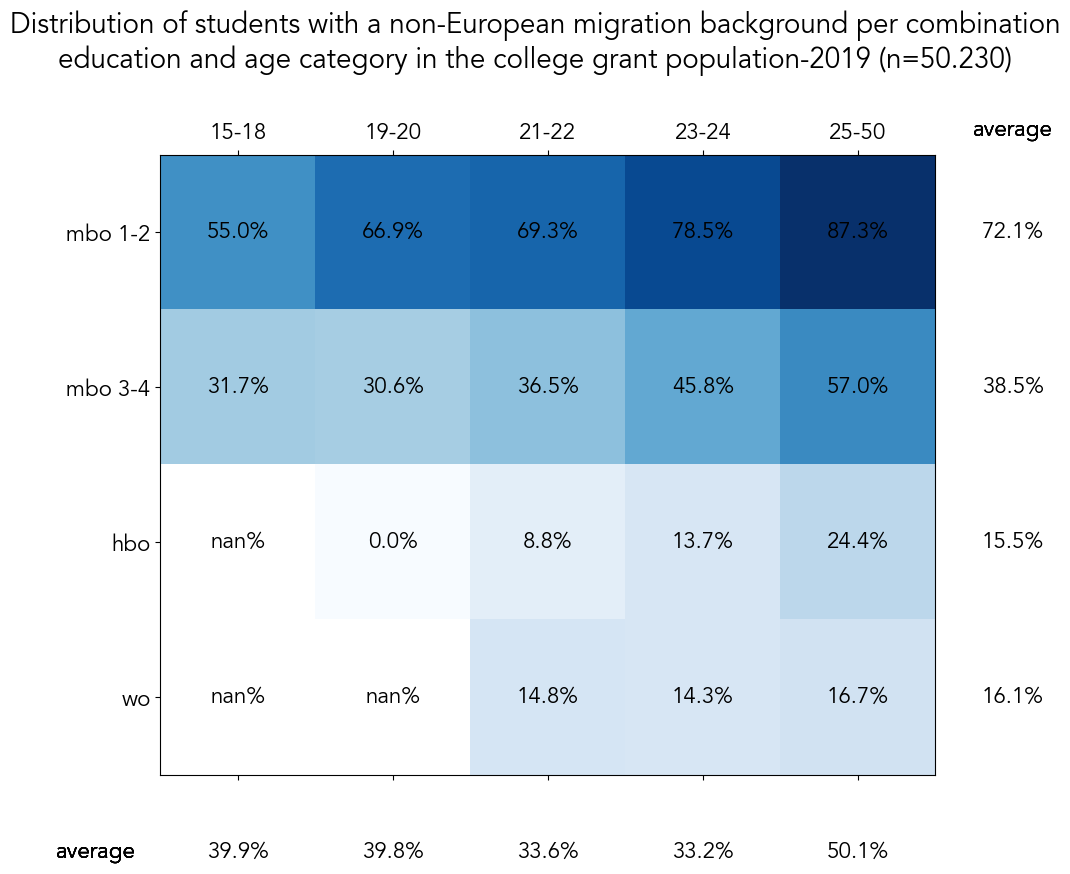

In [8]:
# create matrix for education & age
cat_combinations_education_age = [str(education) + ' & ' + str(age) for education in cat_education for age in cat_age]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_education_age = len(cat_education)
k_cols_matrix_education_age = len(cat_age)

# colors for heatmap
cmap_migr_back_non_eu = 'Blues'

# create the matrix - education x age for non-EU migration background
matrix_education_age_total = get_matrix(df, cat_combinations_education_age, 'Total', k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_eu_migr_back = get_matrix(df, cat_combinations_education_age, metric, k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_eu_migr_back_perc = matrix_education_age_eu_migr_back / matrix_education_age_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education, metric)
marginals_ls_age = marginals(df, cat_age, metric)

# define the row and column names
row_names_education_age = ['mbo 1-2', 'mbo 3-4', 'hbo', 'wo']
col_names_education_age = ['15-18', '19-20', '21-22', '23-24', '25-50']
title_education_age = f'Distribution of students with a non-European migration background per combination\neducation and age category in the college grant population-{year} (n={n_total_pop})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_age_eu_migr_back_perc, 
                  row_names_education_age, 
                  col_names_education_age, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_age],
                  rotation=0,
                  label_as_percentage=True,
                  figure_title=title_education_age)

### mbo students

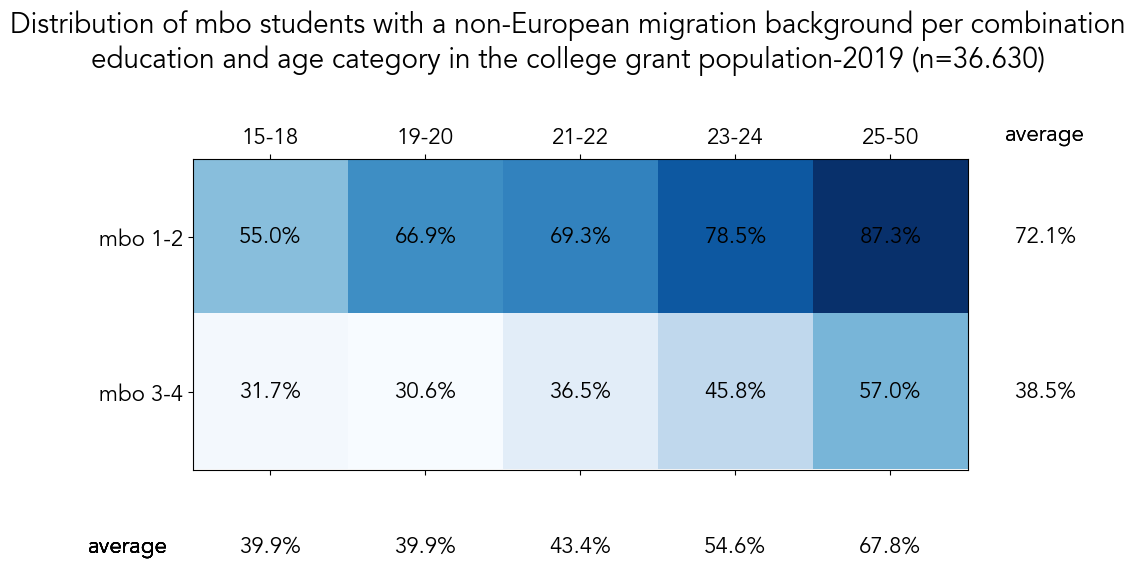

In [9]:
# create matrix for education x age
cat_combinations_education_age = [str(education) + ' & ' + str(age[:-6]) for education in cat_education_mbo for age in cat_age_mbo]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_education_age = len(cat_education_mbo)
k_cols_matrix_education_age = len(cat_age_mbo)

## color maps voor de heatmaps
cmap_migr_back_non_eu = 'Blues'

# create the matrix - onderwijsvorm & leeftijd, total, migrants and childs of migrants, and percentage
matrix_education_age_total = get_matrix(df, cat_combinations_education_age, 'Total', k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_eu_migr_back = get_matrix(df, cat_combinations_education_age, metric, k_rows_matrix_education_age, k_cols_matrix_education_age)
matrix_education_age_eu_migr_back_perc = matrix_education_age_eu_migr_back / matrix_education_age_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education_mbo, metric)
marginals_ls_age = marginals(df, cat_age_mbo, metric)

# define the row and column names
row_names_education_age= ['mbo 1-2', 'mbo 3-4']
col_names_education_age= ['15-18', '19-20', '21-22', '23-24', '25-50']
title_education_age = f'Distribution of mbo students with a non-European migration background per combination\neducation and age category in the college grant population-{year} (n={n_total_pop_mbo})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_age_eu_migr_back_perc, 
                  row_names_education_age, 
                  col_names_education_age, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_age],
                  rotation=0,
                  label_as_percentage=True,
                  figure_title=title_education_age,
                  y_pos=0.8)

# Education x distance

## 2 groups: migration background and Dutch origin

### wo, hbo and mbo students

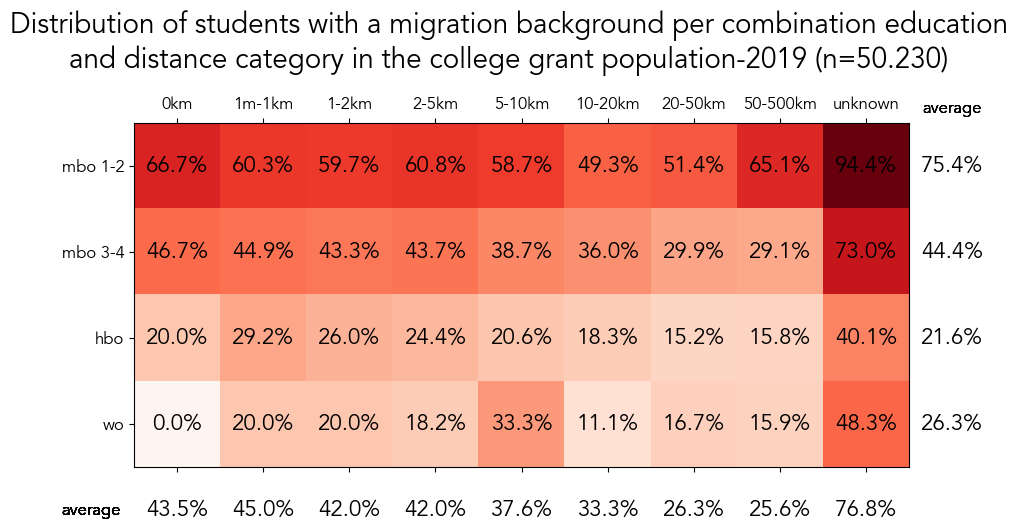

In [10]:
# create matrix for education & age
cat_combinations_education_distance = [str(education) + ' & ' + str(distance) for education in cat_education for distance in cat_distance]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_education_distance = len(cat_education)
k_cols_matrix_education_distance = len(cat_distance)

# colors for heatmap
cmap_migr_back = 'Reds'

# create the matrix - education & age, migration background, and percentage
matrix_education_distance_total = get_matrix(df, cat_combinations_education_distance, 'Total', k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back = get_matrix(df, cat_combinations_education_distance, metric, k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back_perc = matrix_education_distance_migr_back / matrix_education_distance_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education, metric)
marginals_ls_distance = marginals(df, cat_distance, metric)

# define the row and column names
row_names_education_distance = ['mbo 1-2', 'mbo 3-4', 'hbo', 'wo']
col_names_education_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_education_distance = f'Distribution of students with a migration background per combination education\nand distance category in the college grant population-{year} (n={n_total_pop})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_distance_migr_back_perc, 
                  row_names_education_distance, 
                  col_names_education_distance, 
                  cmap=cmap_migr_back, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.78,
                  label_as_percentage=True,
                  figure_title=title_education_distance,
                  fontsize_labels=12)

### mbo students

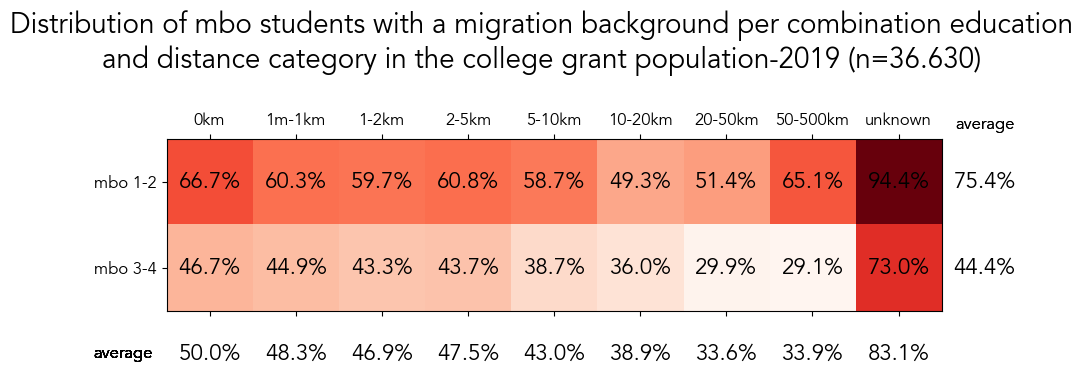

In [11]:
# create matrix for education x age
cat_combinations_education_distance = [str(education) + ' & ' + str(distance[:-6]) for education in cat_education_mbo for distance in cat_distance_mbo]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_education_distance = len(cat_education_mbo)
k_cols_matrix_education_distance = len(cat_distance_mbo)

# colors for heatmap
cmap_migr_back = 'Reds'

# create the matrix - education x age, total, migration background, and percentage
matrix_education_distance_total = get_matrix(df, cat_combinations_education_distance, 'Total', k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back = get_matrix(df, cat_combinations_education_distance, metric, k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back_perc = matrix_education_distance_migr_back / matrix_education_distance_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education_mbo, metric)
marginals_ls_distance = marginals(df, cat_distance_mbo, metric)

# define the row and column names
row_names_education_distance = ['mbo 1-2', 'mbo 3-4']
col_names_education_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_education_distance = f'Distribution of mbo students with a migration background per combination education\nand distance category in the college grant population-{year} (n={n_total_pop_mbo})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_distance_migr_back_perc, 
                  row_names_education_distance, 
                  col_names_education_distance, 
                  cmap=cmap_migr_back, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.71,
                  label_as_percentage=True,
                  figure_title=title_education_distance,
                  fontsize_labels=12)

## 3 groups: (non-)European migration background and Dutch origin

### wo, hbo and mbo students

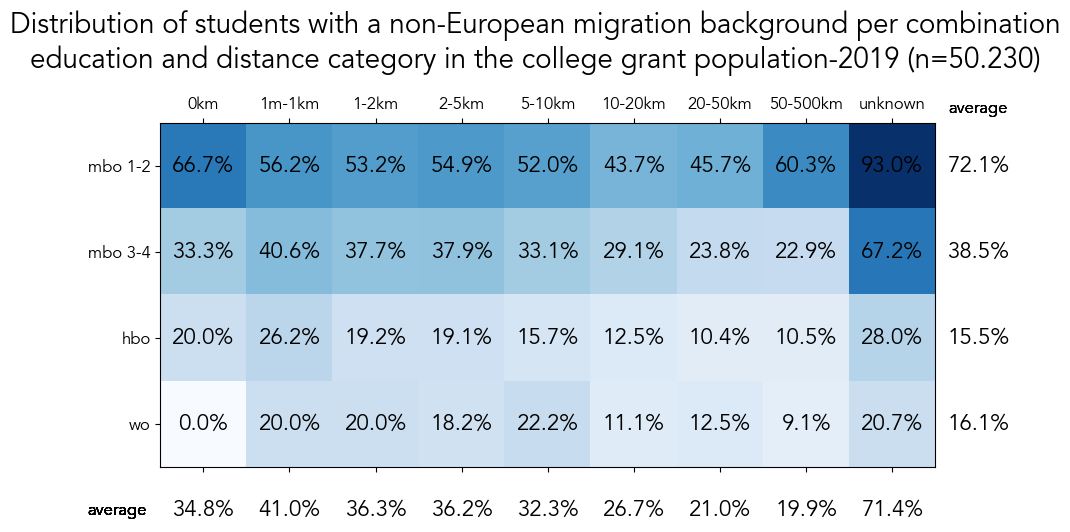

In [12]:
# create matrix for education & age
cat_combinations_education_distance = [str(education) + ' & ' + str(distance) for education in cat_education for distance in cat_distance]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_education_distance = len(cat_education)
k_cols_matrix_education_distance = len(cat_distance)

# colors for heatmap
cmap_migr_back_non_eu = 'Blues'

# create the matrix - onderwijsvorm & leeftijd, total, migrants and childs of migrants, and percentage
matrix_education_distance_total = get_matrix(df, cat_combinations_education_distance, 'Total', k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_eu_migranten_kinderen_migranten = get_matrix(df, cat_combinations_education_distance, metric, k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_eu_migranten_kinderen_migranten_perc = matrix_education_distance_eu_migranten_kinderen_migranten / matrix_education_distance_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education, metric)
marginals_ls_distance = marginals(df, cat_distance, metric)

# define the row and column names
row_names_education_distance = ['mbo 1-2', 'mbo 3-4', 'hbo', 'wo']
col_names_education_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_education_distance = f'Distribution of students with a non-European migration background per combination\neducation and distance category in the college grant population-{year} (n={n_total_pop})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_distance_eu_migranten_kinderen_migranten_perc, 
                  row_names_education_distance, 
                  col_names_education_distance, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.78,
                  label_as_percentage=True,
                  figure_title=title_education_distance,
                  fontsize_labels=12)

### mbo students

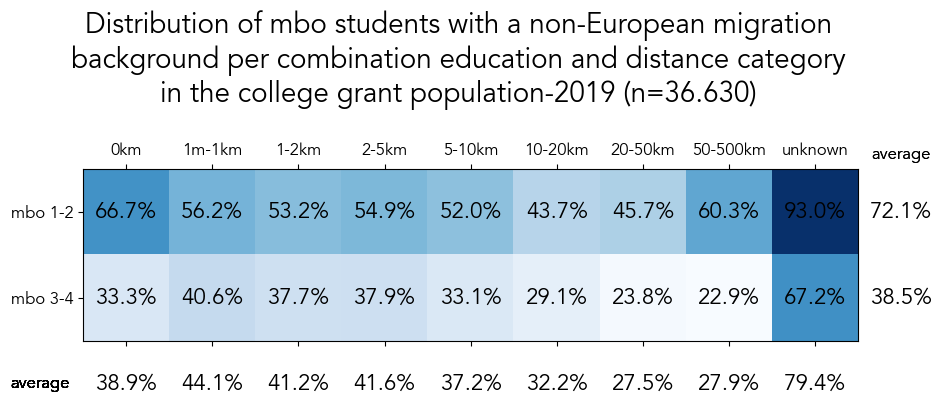

In [13]:
# create matrix for education x age
cat_combinations_education_distance = [str(education) + ' & ' + str(distance[:-6]) for education in cat_education_mbo for distance in cat_distance_mbo]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_education_distance = len(cat_education_mbo)
k_cols_matrix_education_distance = len(cat_distance_mbo)

## color maps voor de heatmaps
cmap_migr_back_non_eu = 'Blues'

# create the matrix - onderwijsvorm & leeftijd, total, migrants and childs of migrants, and percentage
matrix_education_distance_total = get_matrix(df, cat_combinations_education_distance, 'Total', k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back = get_matrix(df, cat_combinations_education_distance, metric, k_rows_matrix_education_distance, k_cols_matrix_education_distance)
matrix_education_distance_migr_back_perc = matrix_education_distance_migr_back / matrix_education_distance_total * 100

# marginals
marginals_ls_education = marginals(df, cat_education_mbo, metric)
marginals_ls_distance = marginals(df, cat_distance_mbo, metric)

# define the row and column names
row_names_education_distance = ['mbo 1-2', 'mbo 3-4']
col_names_education_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_education_distance = f'Distribution of mbo students with a non-European migration\nbackground per combination education and distance category\nin the college grant population-{year} (n={n_total_pop_mbo})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_education_distance_migr_back_perc, 
                  row_names_education_distance, 
                  col_names_education_distance, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_education, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.74,
                  label_as_percentage=True,
                  figure_title=title_education_distance,
                  fontsize_labels=12)

# Age x distance

## 2 groups: migration background and Dutch origin

### wo, hbo and mbo students

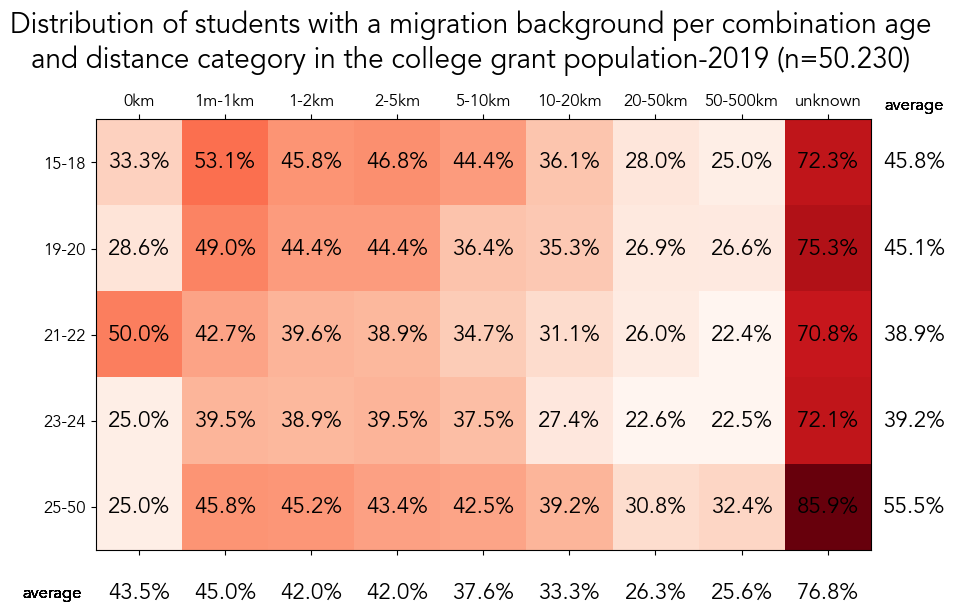

In [14]:
# create matrix for onderwijsvorm & leeftijd
cat_combinations_age_distance = [str(age) + ' & ' + str(distance) for age in cat_age for distance in cat_distance]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_age_distance = len(cat_age)
k_cols_matrix_age_distance = len(cat_distance)

# colors for heatmap
cmap_migr_back = 'Reds'

# create the matrix - age & distance, migration background, and percentage
matrix_age_distance_total = get_matrix(df, cat_combinations_age_distance, 'Total', k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_migranten_kinderen_migranten = get_matrix(df, cat_combinations_age_distance, metric, k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_migranten_kinderen_migranten_perc = matrix_age_distance_migranten_kinderen_migranten / matrix_age_distance_total * 100

# marginals
marginals_ls_age = marginals(df, cat_age, metric)
marginals_ls_distance = marginals(df, cat_distance, metric)

# define the row and column names
row_names_age_distance = ['15-18', '19-20', '21-22', '23-24', '25-50']
col_names_age_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_age_distance = f'Distribution of students with a migration background per combination age\nand distance category in the college grant population-{year} (n={n_total_pop})'


# create the heatmap
create_2d_heatmap(df,
                  matrix_age_distance_migranten_kinderen_migranten_perc, 
                  row_names_age_distance, 
                  col_names_age_distance, 
                  cmap=cmap_migr_back, 
                  annotation_marginals=[marginals_ls_age, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.82,
                  label_as_percentage=True,
                  figure_title=title_age_distance, 
                  fontsize_labels=12)

### mbo students

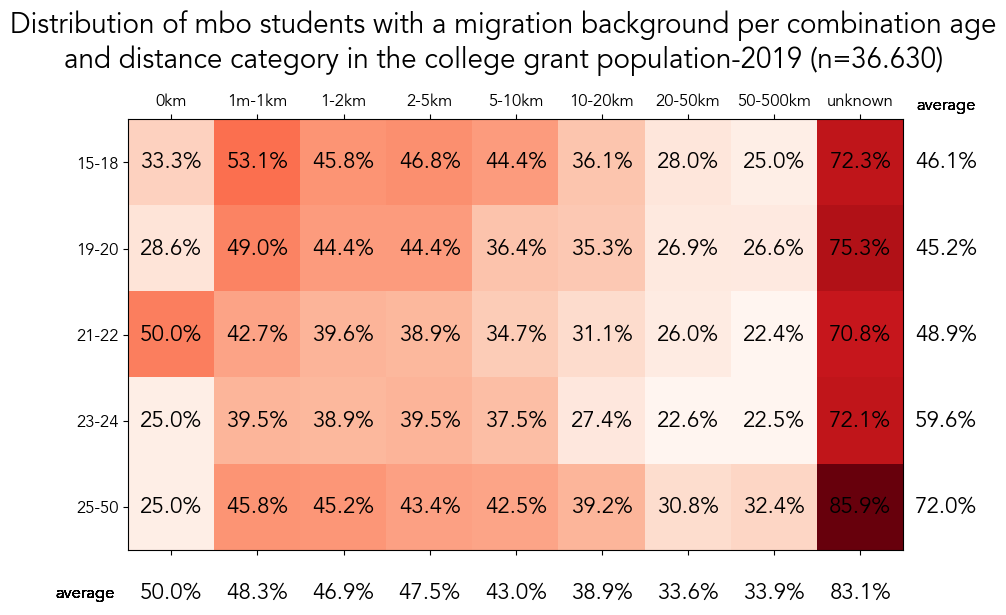

In [15]:
# create matrix for education x distance
cat_combinations_age_distance = [str(age[:-6]) + ' & ' + str(distance[:-6]) for age in cat_age_mbo for distance in cat_distance_mbo]
metric = 'Migration background'

# get the number of rows and columns
k_rows_matrix_age_distance = len(cat_age_mbo)
k_cols_matrix_age_distance = len(cat_distance_mbo)

## color maps voor de heatmaps
cmap_migr_child_migr = 'Reds'

# create the matrix - education x age, migration background, and percentage
matrix_age_distance_total = get_matrix(df, cat_combinations_age_distance, 'Total', k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_migr_back = get_matrix(df, cat_combinations_age_distance, metric, k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_migr_back_perc = matrix_age_distance_migr_back / matrix_age_distance_total * 100

# marginals
marginals_ls_age = marginals(df, cat_age_mbo, metric)
marginals_ls_distance = marginals(df, cat_distance_mbo, metric)

# define the row and column names
row_names_age_distance = ['15-18', '19-20', '21-22', '23-24', '25-50']
col_names_age_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_age_distance = f'Distribution of mbo students with a migration background per combination age\nand distance category in the college grant population-{year} (n={n_total_pop_mbo})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_age_distance_migr_back_perc, 
                  row_names_age_distance, 
                  col_names_age_distance, 
                  cmap=cmap_migr_child_migr, 
                  annotation_marginals=[marginals_ls_age, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.82,
                  label_as_percentage=True,
                  figure_title=title_age_distance, 
                  fontsize_labels=12)

## 3 groups: (non-)European migration background and Dutch origin

### wo, hbo and mbo students

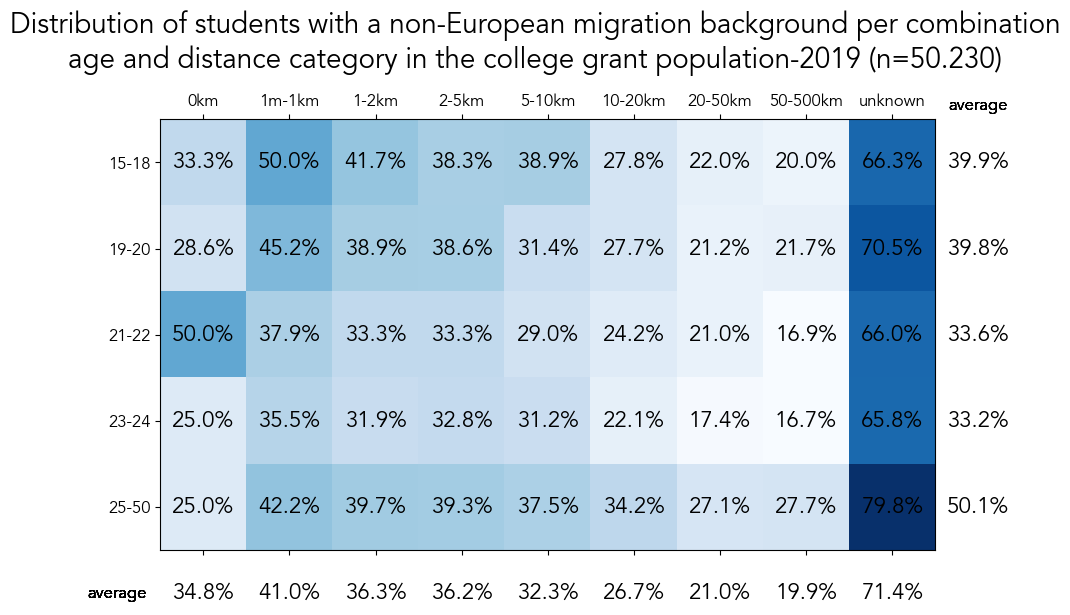

In [16]:
# create matrix for education x distance
cat_combinations_age_distance = [str(age) + ' & ' + str(distance) for age in cat_age for distance in cat_distance]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_age_distance = len(cat_age)
k_cols_matrix_age_distance = len(cat_distance)

# colors for heatmap
cmap_migr_back_non_eu = 'Blues'

# create the matrix - onderwijsvorm & leeftijd, total, migrants and childs of migrants, and percentage
matrix_age_distance_total = get_matrix(df, cat_combinations_age_distance, 'Total', k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_eu_migranten_kinderen_migranten = get_matrix(df, cat_combinations_age_distance, metric, k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_eu_migranten_kinderen_migranten_perc = matrix_age_distance_eu_migranten_kinderen_migranten / matrix_age_distance_total * 100

# marginals
marginals_ls_age = marginals(df, cat_age, metric)
marginals_ls_distance = marginals(df, cat_distance, metric)

# define the row and column names
row_names_age_distance = ['15-18', '19-20', '21-22', '23-24', '25-50']
col_names_age_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_age_distance = f'Distribution of students with a non-European migration background per combination\nage and distance category in the college grant population-{year} (n={n_total_pop})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_age_distance_eu_migranten_kinderen_migranten_perc, 
                  row_names_age_distance, 
                  col_names_age_distance, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_age, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.82,
                  label_as_percentage=True,
                  figure_title=title_age_distance,
                  fontsize_labels=12)

### mbo students

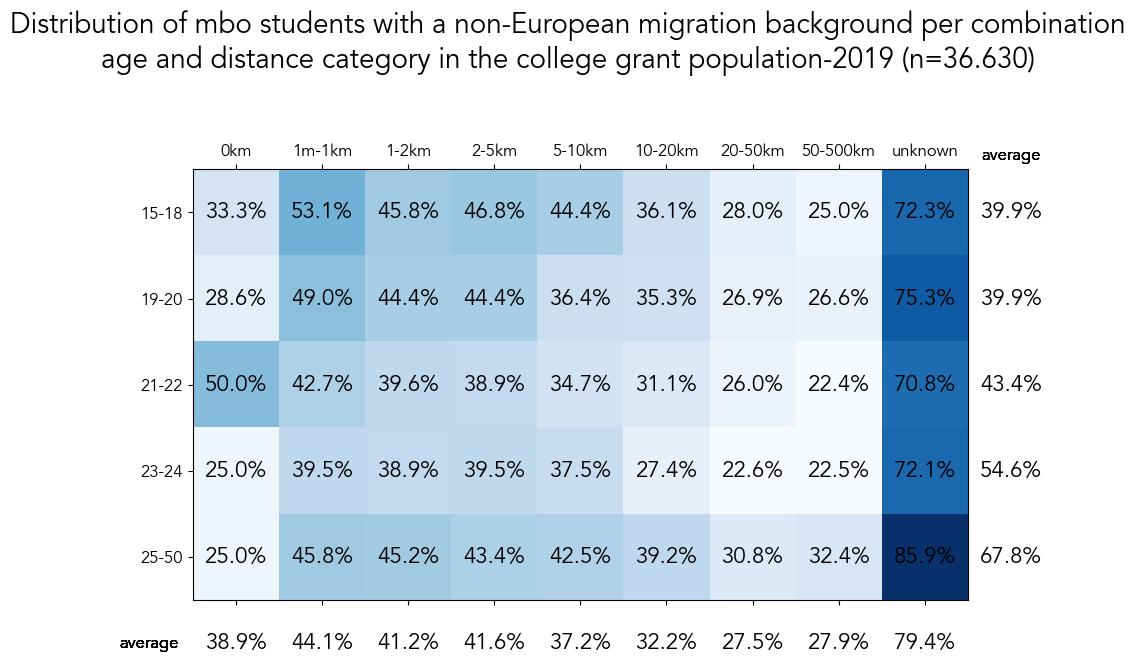

In [19]:
# create matrix for education x distance
cat_combinations_age_distance = [str(age[:-6]) + ' & ' + str(distance[:-6]) for age in cat_age_mbo for distance in cat_distance_mbo]
metric = 'Non-European migration background'

# get the number of rows and columns
k_rows_matrix_age_distance = len(cat_age_mbo)
k_cols_matrix_age_distance = len(cat_distance_mbo)

# colors for heatmap
cmap_migr_back_non_eu = 'Blues'

# create the matrix -  education x distance, migration background, and percentage
matrix_age_distance_total = get_matrix(df, cat_combinations_age_distance, 'Total', k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance_migr_back = get_matrix(df, cat_combinations_age_distance, metric, k_rows_matrix_age_distance, k_cols_matrix_age_distance)
matrix_age_distance__migr_back_perc = matrix_age_distance_migr_back / matrix_age_distance_total * 100

# marginals
marginals_ls_age = marginals(df, cat_age_mbo, metric)
marginals_ls_distance = marginals(df, cat_distance_mbo, metric)

# define the row and column names
row_names_age_distance = ['15-18', '19-20', '21-22', '23-24', '25-50']
col_names_age_distance = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']
title_age_distance = f'Distribution of mbo students with a non-European migration background per combination\nage and distance category in the college grant population-{year} (n={n_total_pop_mbo})'

# create the heatmap
create_2d_heatmap(df,
                  matrix_age_distance_migranten_kinderen_migranten_perc, 
                  row_names_age_distance, 
                  col_names_age_distance, 
                  cmap=cmap_migr_back_non_eu, 
                  annotation_marginals=[marginals_ls_age, marginals_ls_distance],
                  rotation=0,
                  y_pos=0.87,
                  label_as_percentage=True,
                  figure_title=title_age_distance, 
                  fontsize_labels=12)